### Exercice de Programmation en Python : Implémentation d'un Tenseur Autograd

#### Sujet

Dans cet exercice, vous allez implémenter une classe `Tensor` en Python qui représente un tenseur scalaire et son gradient, avec la capacité de construire un graphe de calcul et de calculer les gradients par rétropropagation.

#### Instructions

1. **Définition de la Classe `Tensor`**:
    - Implémentez la classe `Tensor` avec un constructeur pour initialiser les données, le gradient, et les variables internes pour la construction du graphe d'autograd.
    - Implémentez les méthodes pour les opérations arithmétiques, la fonction ReLU, et la rétropropagation.

2. **Création des Tenseurs et Calcul des Opérations**:
    - Créez des instances de `Tensor` avec les valeurs 1.0, 2.0 et 3.0.
    - Effectuez les opérations suivantes sur ces tenseurs :
        - `a = x + y`
        - `b = a * z`
        - `c = b ** 2`
        - `d = c.relu()`

3. **Calcul des Gradients**:
    - Appelez la méthode `backward` sur le tenseur final pour calculer les gradients de tous les tenseurs dans le graphe de calcul.

4. **Affichage des Résultats**:
    - Affichez les tenseurs avec leurs gradients respectifs après la rétropropagation.


In [26]:
class Tensor:
    
    """ stores a single scalar Tensor and its gradient """

    def __init__(self, data, _children=(), _op=''):

        self.data = data
        self.grad = 0.0

        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)

        out = Tensor(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward

        out._prev = set([self, other])
        return out

    def __mul__(self, other):
        
        other = other if isinstance(other, Tensor) else Tensor(other)

        out = Tensor(self.data * other.data, [self, other], '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):

        assert isinstance(other, (int, float)), "only supporting int/float powers for now"

        out = Tensor(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
            
        out._backward = _backward

        return out

    def relu(self):
        # FIXME: implement relu
        out = Tensor(self.data if self.data > 0 else 0, (self,), 'ReLU')

        def _backward():
            self.grad += (1.0 if self.data > 0 else 0.0) * out.grad

        out._backward = _backward
        return out

    def build_topo(self, visited=None, topo=None):
        if self not in visited:
            visited.add(self)
            for child in self._prev:
                child.build_topo(visited=visited, topo=topo)
            topo.append(self)
        return topo

    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        topo = self.build_topo(topo=topo, visited=visited)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Tensor(data={self.data}, grad={self.grad})"

### Test Unitaire

In [27]:
import torch

if __name__ == '__main__':

    x = Tensor(1.0)
    y = Tensor(2.0)

    out = x * 2.0 + y
    out.backward()

    print("x.grad, y.grad")    
    print(x.grad, y.grad)

    print("out")
    print(out.grad)

    x = torch.tensor(1.0, requires_grad=True)
    y = torch.tensor(2.0, requires_grad=True)
    out = x * 2.0 + y
    out.backward()

    assert torch.allclose(x.grad, torch.tensor(2.0))
    assert torch.allclose(y.grad, torch.tensor(1.0))


x.grad, y.grad
2.0 1.0
out
1.0


### Fonctions Mathématiques pour l'Autodifférentiation en mode reverse

#### Objectif

L'objectif de cette partie du TP est d'implémenter des fonctions mathématiques couramment utilisées dans le contexte de l'autodifférentiation en mode reverse. Vous allez créer des fonctions qui calculent à la fois la valeur d'une fonction mathématique et sa dérivée.

Vous allez implémenter plusieurs fonctions mathématiques en utilisant des nombres duals représentés par la classe Tensor. Chaque fonction doit calculer la valeur de la fonction et la dérivée, et renvoyer un objet Tensor contenant ces informations.

#### Fonctions à Implémenter

1. **Logarithme naturel (`log_d`)** :
    - Calcule la valeur du logarithme naturel et sa dérivée.

2. **Exponentielle (`exp_d`)** :
    - Calcule la valeur de l'exponentielle et sa dérivée.

3. **Sinus (`sin_d`)** :
    - Calcule la valeur du sinus et sa dérivée.

4. **Cosinus (`cos_d`)** :
    - Calcule la valeur du cosinus et sa dérivée.

5. **Sigmoïde (`sigmoid_d`)** :
    - Calcule la valeur de la fonction sigmoïde et sa dérivée.

6. **Tangente hyperbolique (`tanh_d`)** :
    - Calcule la valeur de la tangente hyperbolique et sa dérivée.

7. **Tangente (`tan_d`)** :
    - Calcule la valeur de la tangente et sa dérivée.

8. **Racine carrée (`sqrt_d`)** :
    - Calcule la valeur de la racine carrée et sa dérivée.

9. **Puissance (`pow_d`)** :
    - Calcule la valeur de la fonction puissance et sa dérivée.


#### Instructions

1. Implémentez les fonctions décrites ci-dessus.
2. Testez chaque fonction avec des exemples concrets pour vérifier leur bon fonctionnement.
3. Documentez votre code et commentez chaque fonction pour expliquer son fonctionnement.
4. Créez un rapport détaillé décrivant votre implémentation, les tests effectués et les résultats obtenus.



In [28]:
import numpy as np

def log_d(dual_number: Tensor):
    # Implements log(x) with reverse-mode autodiff
    out = Tensor(np.log(dual_number.data), (dual_number,), 'log')
    def _backward():
        dual_number.grad += (1 / dual_number.data) * out.grad
    out._backward = _backward
    return out

def exp_d(dual_number: Tensor):
    # Implements exp(x) with reverse-mode autodiff
    out = Tensor(np.exp(dual_number.data), (dual_number,), 'exp')
    def _backward():
        dual_number.grad += out.data * out.grad
    out._backward = _backward
    return out

def sin_d(dual_number: Tensor):
    # Implements sin(x) with reverse-mode autodiff
    out = Tensor(np.sin(dual_number.data), (dual_number,), 'sin')
    def _backward():
        dual_number.grad += np.cos(dual_number.data) * out.grad
    out._backward = _backward
    return out

def cos_d(dual_number: Tensor):
    # Implements cos(x) with reverse-mode autodiff
    out = Tensor(np.cos(dual_number.data), (dual_number,), 'cos')
    def _backward():
        dual_number.grad += -np.sin(dual_number.data) * out.grad
    out._backward = _backward
    return out

def sigmoid_d(dual_number: Tensor):
    # Implements sigmoid(x) with reverse-mode autodiff
    out = Tensor(1 / (1 + np.exp(-dual_number.data)), (dual_number,), 'sigmoid')
    def _backward():
        dual_number.grad += out.data * (1 - out.data) * out.grad
    out._backward = _backward
    return out

def tanh_d(dual_number: Tensor):
    # Implements tanh(x) with reverse-mode autodiff
    out = Tensor(np.tanh(dual_number.data), (dual_number,), 'tanh')
    def _backward():
        dual_number.grad += (1 - out.data**2) * out.grad
    out._backward = _backward
    return out

def tan_d(dual_number: Tensor):
    # Implements tan(x) with reverse-mode autodiff
    out = Tensor(np.tan(dual_number.data), (dual_number,), 'tan')
    def _backward():
        dual_number.grad += (1 / np.cos(dual_number.data)**2) * out.grad
    out._backward = _backward
    return out

def sqrt_d(dual_number: Tensor):
    # Implements sqrt(x) with reverse-mode autodiff
    out = Tensor(np.sqrt(dual_number.data), (dual_number,), 'sqrt')
    def _backward():
        dual_number.grad += (0.5 / np.sqrt(dual_number.data)) * out.grad
    out._backward = _backward
    return out

def pow_d(dual_number: Tensor, power: int):
    # Implements x^power with reverse-mode autodiff
    assert isinstance(power, (int, float)), "only supporting int/float powers for now"
    out = Tensor(dual_number.data ** power, (dual_number,), f'**{power}')
    def _backward():
        dual_number.grad += (power * dual_number.data ** (power - 1)) * out.grad
    out._backward = _backward
    return out

def softmax_d(dual_number: Tensor):
    # Implements softmax(x) with reverse-mode autodiff
    exp_values = np.exp(dual_number.data - np.max(dual_number.data))  # for numerical stability
    out = Tensor(exp_values / np.sum(exp_values), (dual_number,), 'softmax')
    def _backward():
        # Jacobian of softmax
        s = out.data.reshape(-1, 1)
        jacobian = np.diagflat(s) - np.dot(s, s.T)
        dual_number.grad += np.dot(jacobian, out.grad)
    out._backward = _backward
    return out


### Exercice : Implémentation de la classe Optimizer et de ses variantes

Dans cet exercice, vous allez implémenter une classe `Optimizer` de base, ainsi que plusieurs classes dérivées pour différentes méthodes d'optimisation (SGD, Adagrad, RMSProp, Adam, AdamW). La classe `Optimizer` de base fournit une structure commune pour toutes les méthodes d'optimisation, tandis que chaque classe dérivée implémente une méthode spécifique.

#### Objectifs

1. Comprendre la structure et le rôle d'une classe d'optimiseur.
2. Implémenter la classe `Optimizer` de base.
3. Implémenter les classes dérivées `SGD`, `Adagrad`, `RMSProp`, `Adam`, et `AdamW`.

#### Instructions

1. Implémentez la classe `Optimizer` de base :
   - `__init__(self, params)` : initialise les paramètres à optimiser.
   - `step(self)` : met à jour les paramètres en utilisant leurs gradients.
   - `zero_grad(self)` : remet à zéro les gradients de tous les paramètres.

In [29]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def step(self):
        pass

    def zero_grad(self):
        for param in self.params:
            param.grad = 0.0


## Exercice : Implémentation de SGD

Dans cet exercice, vous allez implémenter une classe `SGD` qui hérite de la classe `Optimizer`. La méthode SGD (Stochastic Gradient Descent) est une méthode d'optimisation classique utilisée pour minimiser une fonction de coût.

### Objectifs

1. Comprendre le fonctionnement de la méthode SGD.
2. Implémenter le constructeur de la classe `SGD`.
3. Implémenter la méthode `step` pour mettre à jour les paramètres du modèle.

### Instructions

1. Implémentez le constructeur `__init__` de la classe `SGD` :
   - `params` : les paramètres à optimiser.
   - `learning_rate` (par défaut 0.01) : le taux d'apprentissage.

2. Implémentez la méthode `step` pour mettre à jour les paramètres :
   - Pour chaque paramètre :
     - Mettez à jour le paramètre en utilisant la formule :
       \[
       \text{paramètre} -= \text{learning_rate} \times \text{gradient}
       \]
     - Remettez le gradient à zéro après la mise à jour.

In [30]:

class SGD(Optimizer):
    def __init__(self, params, learning_rate=0.01):
        super().__init__(params)
        self.learning_rate = learning_rate

    def step(self):
        for param in self.params:
            param.data -= self.learning_rate * param.grad


In [31]:
# Test de l'optimiseur SGD avec une fonction simple : f(x) = (x - 3)^2
x = Tensor(0.0)
optimizer = SGD([x], learning_rate=0.1)

for i in range(20):
    # Réinitialisation du gradient
    x.grad = 0.0

    # Calcul de la perte et du gradient
    loss = (x - 3) ** 2
    loss.backward()

    # Mise à jour du paramètre
    optimizer.step()

    print(f"Iteration {i+1}: x = {x.data:.4f}, loss = {loss.data:.4f}")

Iteration 1: x = 0.6000, loss = 9.0000
Iteration 2: x = 1.0800, loss = 5.7600
Iteration 3: x = 1.4640, loss = 3.6864
Iteration 4: x = 1.7712, loss = 2.3593
Iteration 5: x = 2.0170, loss = 1.5099
Iteration 6: x = 2.2136, loss = 0.9664
Iteration 7: x = 2.3709, loss = 0.6185
Iteration 8: x = 2.4967, loss = 0.3958
Iteration 9: x = 2.5973, loss = 0.2533
Iteration 10: x = 2.6779, loss = 0.1621
Iteration 11: x = 2.7423, loss = 0.1038
Iteration 12: x = 2.7938, loss = 0.0664
Iteration 13: x = 2.8351, loss = 0.0425
Iteration 14: x = 2.8681, loss = 0.0272
Iteration 15: x = 2.8944, loss = 0.0174
Iteration 16: x = 2.9156, loss = 0.0111
Iteration 17: x = 2.9324, loss = 0.0071
Iteration 18: x = 2.9460, loss = 0.0046
Iteration 19: x = 2.9568, loss = 0.0029
Iteration 20: x = 2.9654, loss = 0.0019


## Exercice : Implémentation de RMSProp

Dans cet exercice, vous allez implémenter une classe `RMSProp` qui hérite de la classe `Optimizer`. La méthode RMSProp (Root Mean Square Propagation) est une méthode d'optimisation adaptative qui divise le taux d'apprentissage par une moyenne exponentielle glissante des carrés des gradients passés.

### Objectifs

1. Comprendre le fonctionnement de la méthode RMSProp.
2. Implémenter le constructeur de la classe `RMSProp`.
3. Implémenter la méthode `step` pour mettre à jour les paramètres du modèle.

### Instructions

1. Implémentez le constructeur `__init__` de la classe `RMSProp` :
   - `params` : les paramètres à optimiser.
   - `learning_rate` (par défaut 0.01) : le taux d'apprentissage.
   - `decay` (par défaut 0.9) : le taux de décroissance pour la moyenne exponentielle des carrés des gradients.
   - Initialisez un cache pour chaque paramètre, qui sera utilisé pour stocker la moyenne exponentielle des carrés des gradients.

2. Implémentez la méthode `step` pour mettre à jour les paramètres :
   - Pour chaque paramètre et cache :
     - Mettez à jour le cache en utilisant la formule : 
       \[
       \text{cache} = \text{decay} \times \text{cache} + (1 - \text{decay}) \times (\text{gradient})^2
       \]
     - Mettez à jour le paramètre en utilisant la formule :
       \[
       \text{paramètre} -= \frac{\text{learning_rate} \times \text{gradient}}{\sqrt{\text{cache}} + 1e-8}
       \]
     - Remettez le gradient à zéro après la mise à jour.

In [32]:
class RMSProp(Optimizer):
    def __init__(self, params, learning_rate=0.01, decay=0.9):
        super().__init__(params)
        self.learning_rate = learning_rate
        self.decay = decay
        self.cache = [Tensor(0.0) for _ in params]

    def step(self):
        """
        Mise à jour des paramètres en utilisant la méthode RMSProp.
        La méthode RMSProp (Root Mean Square Propagation) est une méthode d'optimisation adaptative 
        qui divise le taux d'apprentissage par une moyenne exponentielle glissante des carrés des gradients passés.
        """
        for p, c in zip(self.params, self.cache):
            c.data = self.decay * c.data + (1 - self.decay) * p.grad**2
            p.data -= (self.learning_rate * p.grad) / (np.sqrt(c.data) + 1e-8)

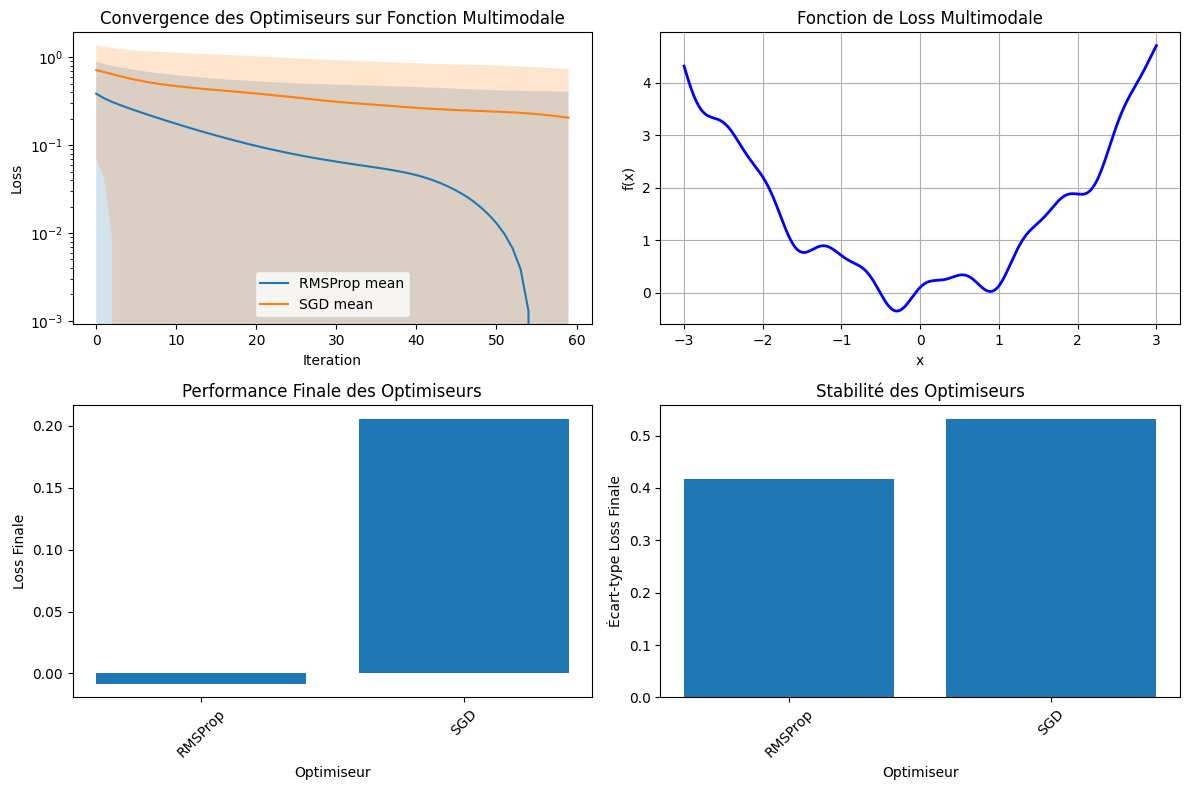


Statistiques finales:
RMSProp: Loss finale = -0.0087 ± 0.4168
SGD: Loss finale = 0.2059 ± 0.5309


In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction de loss multimodale avec plusieurs minima locaux
def multimodal_loss(x):
    """
    Fonction multimodale avec plusieurs minima locaux
    f(x) = 0.5 * x^2 + 0.3 * sin(5*x) + 0.1 * cos(10*x)
    """
    return 0.5 * (x ** 2) + 0.3 * sin_d(5 * x) + 0.1 * cos_d(10 * x)

n_runs = 30
n_iter = 60  # Augmenté pour mieux voir la convergence
optimizers_classes = [
    ("RMSProp", lambda x: RMSProp([x], learning_rate=0.01, decay=0.9)),
    ("SGD", lambda x: SGD([x], learning_rate=0.01)),
]

results = {}

for name, opt_fn in optimizers_classes:
    all_losses = []
    for run in range(n_runs):
        # Initialisation aléatoire pour explorer différents minima
        x = Tensor(np.random.uniform(-2, 2))
        optimizer = opt_fn(x)
        losses = []
        for i in range(n_iter):
            x.grad = 0.0
            loss = multimodal_loss(x)
            loss.backward()
            optimizer.step()
            losses.append(loss.data)
        all_losses.append(losses)
    all_losses = np.array(all_losses)
    mean_losses = np.mean(all_losses, axis=0)
    std_losses = np.std(all_losses, axis=0)
    results[name] = (mean_losses, std_losses)

# Visualisation des résultats
plt.figure(figsize=(12, 8))

# Graphique 1: Convergence des optimiseurs
plt.subplot(2, 2, 1)
for name, (mean_losses, std_losses) in results.items():
    plt.plot(mean_losses, label=f"{name} mean")
    plt.fill_between(range(n_iter), mean_losses - std_losses, mean_losses + std_losses, alpha=0.2)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Convergence des Optimiseurs sur Fonction Multimodale")
plt.legend()
plt.yscale('log')

# Graphique 2: Visualisation de la fonction multimodale
plt.subplot(2, 2, 2)
x_range = np.linspace(-3, 3, 1000)
y_range = []
for x_val in x_range:
    x_tensor = Tensor(x_val)
    loss = multimodal_loss(x_tensor)
    y_range.append(loss.data)
plt.plot(x_range, y_range, 'b-', linewidth=2)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Fonction de Loss Multimodale")
plt.grid(True)

# Graphique 3: Valeurs finales atteintes par chaque optimiseur
plt.subplot(2, 2, 3)
final_losses = [results[name][0][-1] for name in results.keys()]
optimizer_names = list(results.keys())
plt.bar(optimizer_names, final_losses)
plt.xlabel("Optimiseur")
plt.ylabel("Loss Finale")
plt.title("Performance Finale des Optimiseurs")
plt.xticks(rotation=45)

# Graphique 4: Écart-type des losses finales
plt.subplot(2, 2, 4)
final_stds = [results[name][1][-1] for name in results.keys()]
plt.bar(optimizer_names, final_stds)
plt.xlabel("Optimiseur")
plt.ylabel("Écart-type Loss Finale")
plt.title("Stabilité des Optimiseurs")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Affichage des statistiques
print("\nStatistiques finales:")
for name, (mean_losses, std_losses) in results.items():
    print(f"{name}: Loss finale = {mean_losses[-1]:.4f} ± {std_losses[-1]:.4f}")


## Exercice : Implémentation de Adagrad

Dans cet exercice, vous allez implémenter une classe `Adagrad` qui hérite de la classe `Optimizer`. La méthode Adagrad (Adaptive Gradient) est une méthode d'optimisation adaptative qui divise le taux d'apprentissage par la racine carrée de la somme cumulée des carrés des gradients passés.

### Objectifs

1. Comprendre le fonctionnement de la méthode Adagrad.
2. Implémenter le constructeur de la classe `Adagrad`.
3. Implémenter la méthode `step` pour mettre à jour les paramètres du modèle.

### Instructions

1. Implémentez le constructeur `__init__` de la classe `Adagrad` :
   - `params` : les paramètres à optimiser.
   - `learning_rate` (par défaut 0.01) : le taux d'apprentissage.
   - Initialisez un cache pour chaque paramètre, qui sera utilisé pour stocker la somme cumulée des carrés des gradients.

2. Implémentez la méthode `step` pour mettre à jour les paramètres :
   - Pour chaque paramètre et cache :
     - Mettez à jour le cache en utilisant la formule : 
       \[
       \text{cache} += (\text{gradient})^2
       \]
     - Mettez à jour le paramètre en utilisant la formule :
       \[
       \text{paramètre} -= \frac{\text{learning_rate} \times \text{gradient}}{\sqrt{\text{cache}} + 1e-8}
       \]
     - Remettez le gradient à zéro après la mise à jour.

In [34]:
class Adagrad(Optimizer):
    def __init__(self, params, learning_rate=0.01):
        super().__init__(params)
        self.learning_rate = learning_rate
        self.cache = [Tensor(0.0) for _ in params]

    def step(self):
        """
        Mise à jour des paramètres en utilisant la méthode Adagrad.
        La méthode Adagrad (Adaptive Gradient) est une méthode d'optimisation adaptative 
        qui divise le taux d'apprentissage par la racine carrée de la somme cumulée des carrés des gradients passés.
        """
        for p, c in zip(self.params, self.cache):
            c.data += p.grad**2
            p.data -= (self.learning_rate * p.grad) / (np.sqrt(c.data) + 1e-8)

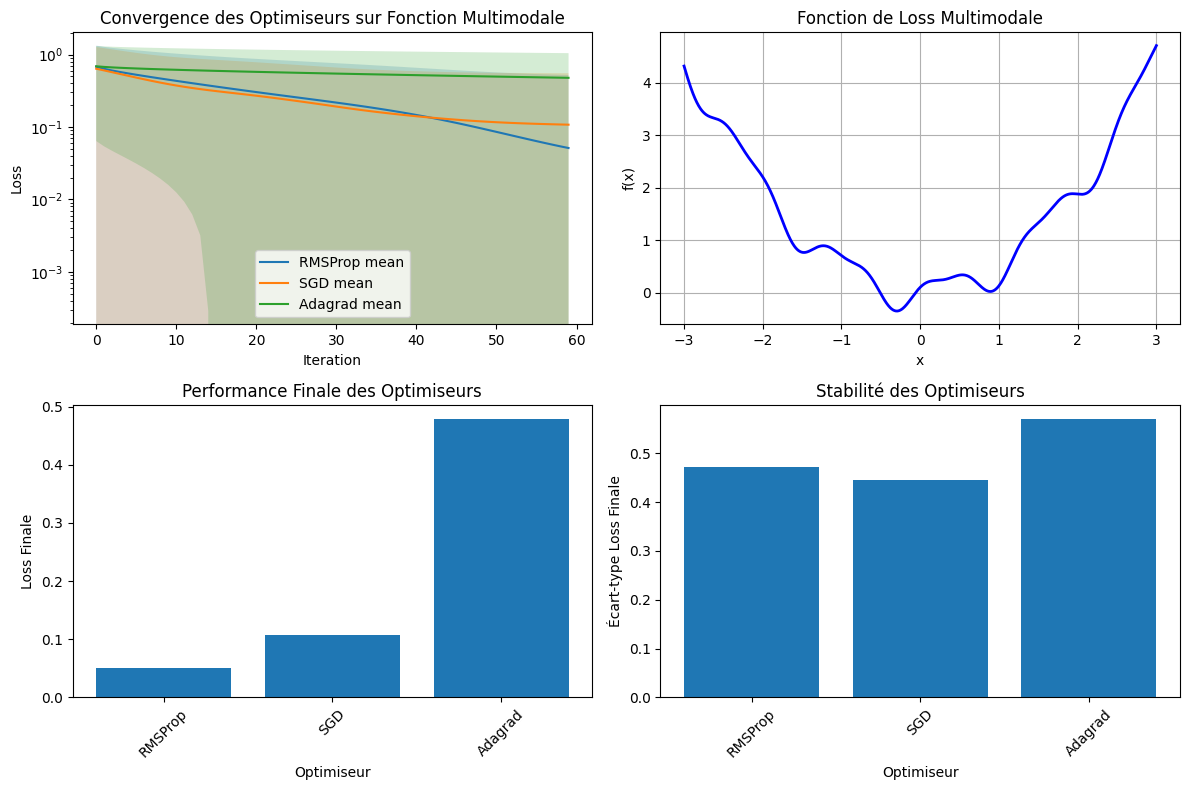


Statistiques finales:
RMSProp: Loss finale = 0.0513 ± 0.4718
SGD: Loss finale = 0.1078 ± 0.4458
Adagrad: Loss finale = 0.4783 ± 0.5695


In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction de loss multimodale avec plusieurs minima locaux
def multimodal_loss(x):
    """
    Fonction multimodale avec plusieurs minima locaux
    f(x) = 0.5 * x^2 + 0.3 * sin(5*x) + 0.1 * cos(10*x)
    """
    return 0.5 * (x ** 2) + 0.3 * sin_d(5 * x) + 0.1 * cos_d(10 * x)

n_runs = 300
n_iter = 60  # Augmenté pour mieux voir la convergence
optimizers_classes = [
    ("RMSProp", lambda x: RMSProp([x], learning_rate=0.01, decay=0.9)),
    ("SGD", lambda x: SGD([x], learning_rate=0.01)),
    ("Adagrad", lambda x: Adagrad([x], learning_rate=0.01)),
]

results = {}

for name, opt_fn in optimizers_classes:
    all_losses = []
    for run in range(n_runs):
        # Initialisation aléatoire pour explorer différents minima
        x = Tensor(np.random.uniform(-2, 2))
        optimizer = opt_fn(x)
        losses = []
        for i in range(n_iter):
            x.grad = 0.0
            loss = multimodal_loss(x)
            loss.backward()
            optimizer.step()
            losses.append(loss.data)
        all_losses.append(losses)
    all_losses = np.array(all_losses)
    mean_losses = np.mean(all_losses, axis=0)
    std_losses = np.std(all_losses, axis=0)
    results[name] = (mean_losses, std_losses)

# Visualisation des résultats
plt.figure(figsize=(12, 8))

# Graphique 1: Convergence des optimiseurs
plt.subplot(2, 2, 1)
for name, (mean_losses, std_losses) in results.items():
    plt.plot(mean_losses, label=f"{name} mean")
    plt.fill_between(range(n_iter), mean_losses - std_losses, mean_losses + std_losses, alpha=0.2)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Convergence des Optimiseurs sur Fonction Multimodale")
plt.legend()
plt.yscale('log')

# Graphique 2: Visualisation de la fonction multimodale
plt.subplot(2, 2, 2)
x_range = np.linspace(-3, 3, 1000)
y_range = []
for x_val in x_range:
    x_tensor = Tensor(x_val)
    loss = multimodal_loss(x_tensor)
    y_range.append(loss.data)
plt.plot(x_range, y_range, 'b-', linewidth=2)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Fonction de Loss Multimodale")
plt.grid(True)

# Graphique 3: Valeurs finales atteintes par chaque optimiseur
plt.subplot(2, 2, 3)
final_losses = [results[name][0][-1] for name in results.keys()]
optimizer_names = list(results.keys())
plt.bar(optimizer_names, final_losses)
plt.xlabel("Optimiseur")
plt.ylabel("Loss Finale")
plt.title("Performance Finale des Optimiseurs")
plt.xticks(rotation=45)

# Graphique 4: Écart-type des losses finales
plt.subplot(2, 2, 4)
final_stds = [results[name][1][-1] for name in results.keys()]
plt.bar(optimizer_names, final_stds)
plt.xlabel("Optimiseur")
plt.ylabel("Écart-type Loss Finale")
plt.title("Stabilité des Optimiseurs")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Affichage des statistiques
print("\nStatistiques finales:")
for name, (mean_losses, std_losses) in results.items():
    print(f"{name}: Loss finale = {mean_losses[-1]:.4f} ± {std_losses[-1]:.4f}")


## Exercice : Implémentation de Adam

Dans cet exercice, vous allez implémenter une classe `Adam` qui hérite de la classe `Optimizer`. La méthode Adam (Adaptive Moment Estimation) est une méthode d'optimisation adaptative qui utilise une moyenne exponentielle glissante des gradients passés et de leurs carrés pour estimer la première et la deuxième moments des gradients.

### Objectifs

1. Comprendre le fonctionnement de la méthode Adam.
2. Implémenter le constructeur de la classe `Adam`.
3. Implémenter la méthode `step` pour mettre à jour les paramètres du modèle.

### Instructions

1. Implémentez le constructeur `__init__` de la classe `Adam` :
   - `params` : les paramètres à optimiser.
   - `learning_rate` (par défaut 0.001) : le taux d'apprentissage.
   - `beta1` (par défaut 0.9) : le coefficient de décroissance exponentielle pour les moyennes des gradients.
   - `beta2` (par défaut 0.999) : le coefficient de décroissance exponentielle pour les moyennes des carrés des gradients.
   - `eps` (par défaut 1e-8) : une petite valeur pour éviter la division par zéro.
   - Initialisez les moments `m` et `v` pour chaque paramètre à 0.0.
   - Initialisez le compteur de temps `t` à 0.

2. Implémentez la méthode `step` pour mettre à jour les paramètres :
   - Incrémentez le compteur de temps `t`.
   - Pour chaque paramètre, moment `m`, et moment `v` :
     - Mettez à jour le moment `m` en utilisant la formule :
       \[
       m = \beta1 \times m + (1 - \beta1) \times \text{gradient}
       \]
     - Mettez à jour le moment `v` en utilisant la formule :
       \[
       v = \beta2 \times v + (1 - \beta2) \times (\text{gradient})^2
       \]
     - Calculez les moments corrigés `m_hat` et `v_hat` :
       \[
       m\_hat = \frac{m}{1 - \beta1^t}
       \]
       \[
       v\_hat = \frac{v}{1 - \beta2^t}
       \]
     - Mettez à jour le paramètre en utilisant la formule :
       \[
       \text{paramètre} -= \frac{\text{learning_rate} \times m\_hat}{\sqrt{v\_hat} + \eps}
       \]
     - Remettez le gradient à zéro après la mise à jour.

In [36]:
class Adam(Optimizer):
    def __init__(self, params, learning_rate=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = [0.0 for _ in params]
        self.v = [0.0 for _ in params]
        self.t = 0

    def step(self):
        """
        Mise à jour des paramètres en utilisant la méthode Adam.
        La méthode Adam (Adaptive Moment Estimation) est une méthode d'optimisation adaptative 
        qui utilise une moyenne exponentielle glissante des gradients passés et de leurs carrés 
        pour estimer la première et la deuxième moments des gradients.
        """
        self.t += 1

        for p, m, v in zip(self.params, self.m, self.v):
            m = self.beta1 * m + (1 - self.beta1) * p.grad
            v = self.beta2 * v + (1 - self.beta2) * p.grad**2

            m_hat = m / (1 - self.beta1**self.t)
            v_hat = v / (1 - self.beta2**self.t)

            p.data -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.eps)

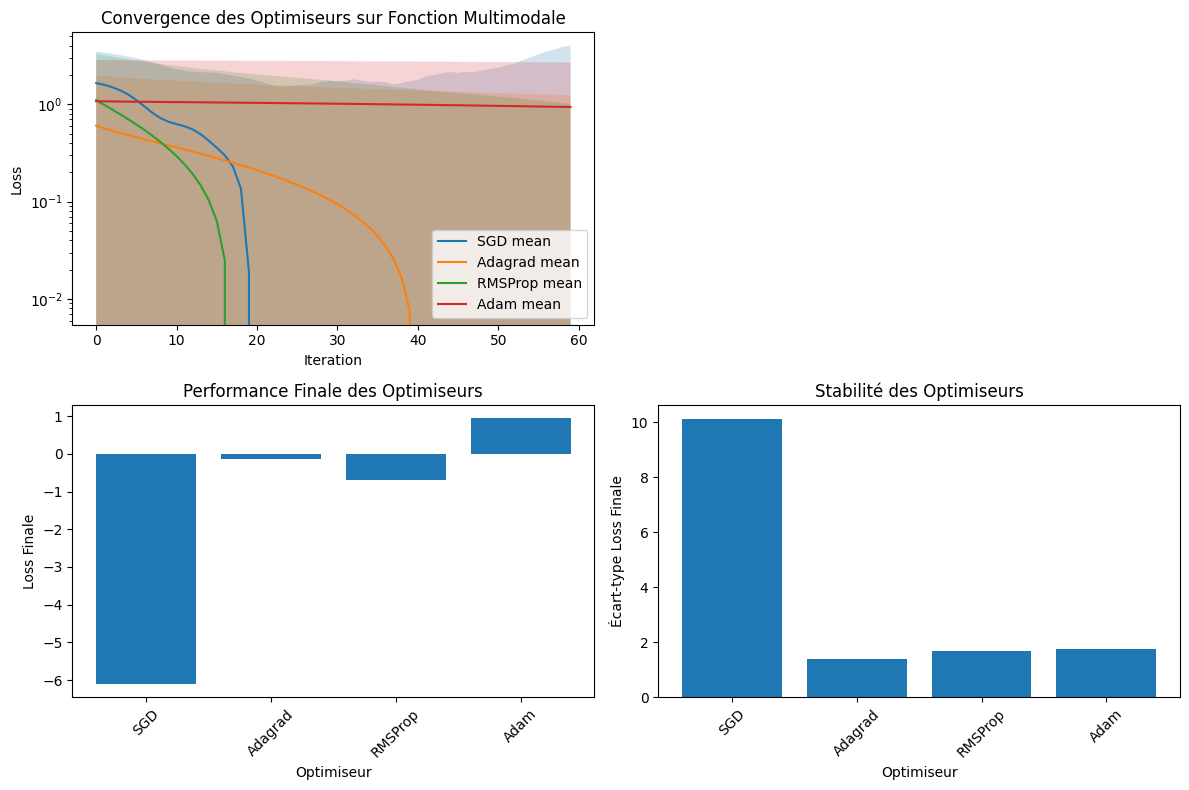


Statistiques finales:
SGD: Loss finale = -6.1054 ± 10.1081
Adagrad: Loss finale = -0.1455 ± 1.3822
RMSProp: Loss finale = -0.6831 ± 1.6898
Adam: Loss finale = 0.9369 ± 1.7501


In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction de loss multimodale avec plusieurs minima locaux
def multimodal_loss(x, y, z, w):
    return 0.5 * (x ** 2) + 0.3 * sin_d(5 * y) + 0.1 * cos_d(10 * z) + 0.2 * sin_d(3 * w) + 0.5*x*y

n_runs = 30
n_iter = 60  # Augmenté pour mieux voir la convergence
optimizers_classes = [
    ("SGD", lambda l: SGD(l, learning_rate=0.01)),
    ("Adagrad", lambda l: Adagrad(l, learning_rate=0.01)),
    ("RMSProp", lambda l: RMSProp(l, learning_rate=0.01, decay=0.9)),
    ("Adam", lambda l: Adam(l, learning_rate=0.001, beta1=0.9, beta2=0.999, eps=1e-8)),
]
results = {}

for name, opt_fn in optimizers_classes:
    all_losses = []
    for run in range(n_runs):
        # Initialisation aléatoire pour explorer différents minima
        x = Tensor(np.random.uniform(-2, 2))
        y = Tensor(np.random.uniform(3, 3))
        z = Tensor(np.random.uniform(-2, 9))
        w = Tensor(np.random.uniform(0, 1))
        optimizer = opt_fn([x, y, z, w])
        losses = []
        for i in range(n_iter):
            x.grad = 0.0
            loss = multimodal_loss(x, y, z, w)
            loss.backward()
            optimizer.step()
            losses.append(loss.data)
        all_losses.append(losses)
    all_losses = np.array(all_losses)
    mean_losses = np.mean(all_losses, axis=0)
    std_losses = np.std(all_losses, axis=0)
    results[name] = (mean_losses, std_losses)

# Visualisation des résultats
plt.figure(figsize=(12, 8))

# Graphique 1: Convergence des optimiseurs
plt.subplot(2, 2, 1)
for name, (mean_losses, std_losses) in results.items():
    plt.plot(mean_losses, label=f"{name} mean")
    plt.fill_between(range(n_iter), mean_losses - std_losses, mean_losses + std_losses, alpha=0.2)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Convergence des Optimiseurs sur Fonction Multimodale")
plt.legend()
plt.yscale('log')

# Graphique 3: Valeurs finales atteintes par chaque optimiseur
plt.subplot(2, 2, 3)
final_losses = [results[name][0][-1] for name in results.keys()]
optimizer_names = list(results.keys())
plt.bar(optimizer_names, final_losses)
plt.xlabel("Optimiseur")
plt.ylabel("Loss Finale")
plt.title("Performance Finale des Optimiseurs")
plt.xticks(rotation=45)

# Graphique 4: Écart-type des losses finales
plt.subplot(2, 2, 4)
final_stds = [results[name][1][-1] for name in results.keys()]
plt.bar(optimizer_names, final_stds)
plt.xlabel("Optimiseur")
plt.ylabel("Écart-type Loss Finale")
plt.title("Stabilité des Optimiseurs")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Affichage des statistiques
print("\nStatistiques finales:")
for name, (mean_losses, std_losses) in results.items():
    print(f"{name}: Loss finale = {mean_losses[-1]:.4f} ± {std_losses[-1]:.4f}")

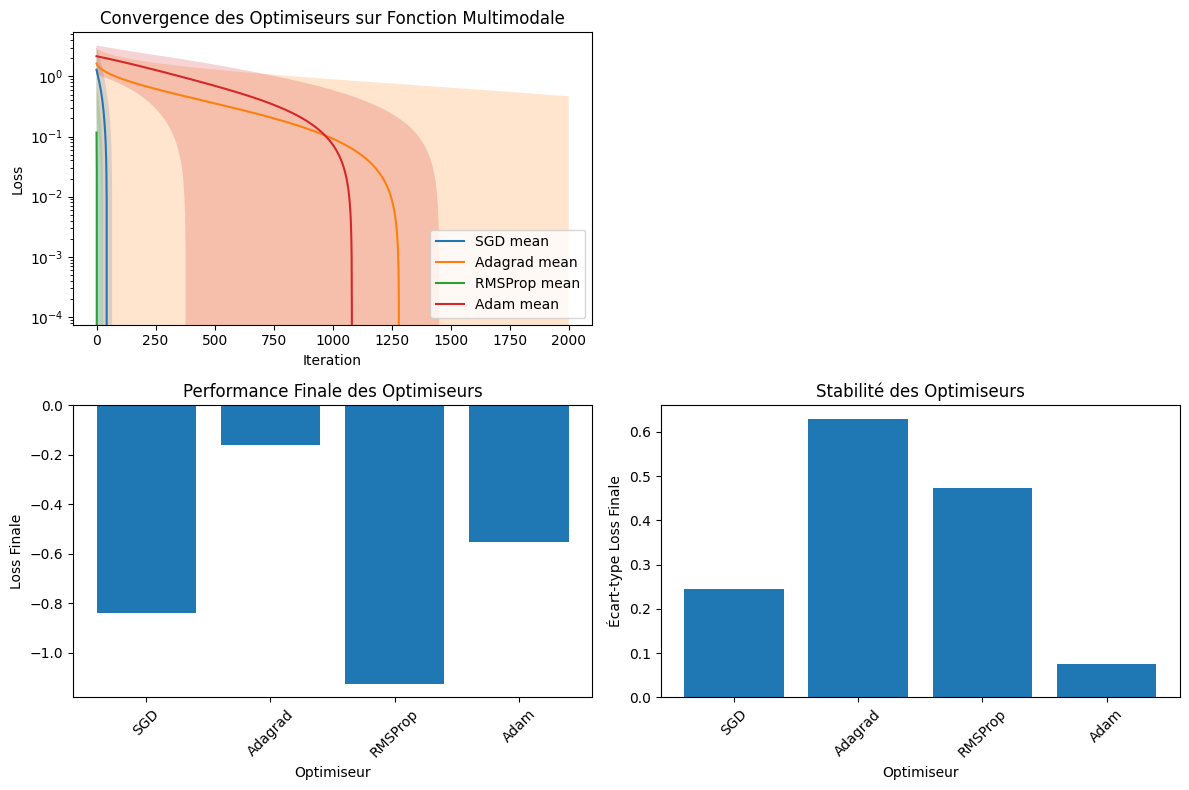


Statistiques finales:
SGD: Loss finale = -0.8375 ± 0.2439
Adagrad: Loss finale = -0.1621 ± 0.6287
RMSProp: Loss finale = -1.1233 ± 0.4738
Adam: Loss finale = -0.5519 ± 0.0750


In [38]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Fonction de loss multimodale (utilise torch)
def multimodal_loss(x, y, z, w):
    return 0.5 * (x ** 2) + 0.3 * torch.sin(5 * y) + 0.1 * torch.cos(10 * z) + 0.2 * torch.sin(3 * w) + 0.5 * x * y

n_runs = 5
n_iter = 2000
optimizers_classes = [
    ("SGD", lambda params: optim.SGD(params, lr=0.01)),
    ("Adagrad", lambda params: optim.Adagrad(params, lr=0.01)),
    ("RMSProp", lambda params: optim.RMSprop(params, lr=0.01, alpha=0.9)),
    ("Adam", lambda params: optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-8)),
]
results = {}

for name, opt_fn in optimizers_classes:
    all_losses = []
    for run in range(n_runs):
        # Initialisation aléatoire avec torch
        x = torch.tensor([torch.empty(1).uniform_(-2, 2).item()], requires_grad=True)
        y = torch.tensor([torch.empty(1).uniform_(-3, 3).item()], requires_grad=True)
        z = torch.tensor([torch.empty(1).uniform_(-2, 9).item()], requires_grad=True)
        w = torch.tensor([torch.empty(1).uniform_(0, 1).item()], requires_grad=True)
        params = [x, y, z, w]
        optimizer = opt_fn(params)
        losses = []
        for i in range(n_iter):
            optimizer.zero_grad()
            loss = multimodal_loss(x, y, z, w)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        all_losses.append(losses)
    all_losses = torch.tensor(all_losses)
    mean_losses = all_losses.mean(dim=0).numpy()
    std_losses = all_losses.std(dim=0).numpy()
    results[name] = (mean_losses, std_losses)

# Visualisation des résultats
plt.figure(figsize=(12, 8))

# Graphique 1: Convergence des optimiseurs
plt.subplot(2, 2, 1)
for name, (mean_losses, std_losses) in results.items():
    plt.plot(mean_losses, label=f"{name} mean")
    plt.fill_between(range(n_iter), mean_losses - std_losses, mean_losses + std_losses, alpha=0.2)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Convergence des Optimiseurs sur Fonction Multimodale")
plt.legend()
plt.yscale('log')

# Graphique 3: Valeurs finales atteintes par chaque optimiseur
plt.subplot(2, 2, 3)
final_losses = [results[name][0][-1] for name in results.keys()]
optimizer_names = list(results.keys())
plt.bar(optimizer_names, final_losses)
plt.xlabel("Optimiseur")
plt.ylabel("Loss Finale")
plt.title("Performance Finale des Optimiseurs")
plt.xticks(rotation=45)

# Graphique 4: Écart-type des losses finales
plt.subplot(2, 2, 4)
final_stds = [results[name][1][-1] for name in results.keys()]
plt.bar(optimizer_names, final_stds)
plt.xlabel("Optimiseur")
plt.ylabel("Écart-type Loss Finale")
plt.title("Stabilité des Optimiseurs")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Affichage des statistiques
print("\nStatistiques finales:")
for name, (mean_losses, std_losses) in results.items():
    print(f"{name}: Loss finale = {mean_losses[-1]:.4f} ± {std_losses[-1]:.4f}")

## Exercice : Implémentation de AdamW

Dans cet exercice, vous allez implémenter une classe `AdamW` qui hérite de la classe `Optimizer`. La méthode AdamW (Adaptive Moment Estimation with Weight Decay) est une variante de la méthode Adam qui ajoute une régularisation L2 (ou weight decay) aux mises à jour des paramètres.

### Objectifs

1. Comprendre le fonctionnement de la méthode AdamW.
2. Implémenter le constructeur de la classe `AdamW`.
3. Implémenter la méthode `step` pour mettre à jour les paramètres du modèle.

### Instructions

1. Implémentez le constructeur `__init__` de la classe `AdamW` :
   - `params` : les paramètres à optimiser.
   - `learning_rate` (par défaut 0.001) : le taux d'apprentissage.
   - `beta1` (par défaut 0.9) : le coefficient de décroissance exponentielle pour les moyennes des gradients.
   - `beta2` (par défaut 0.999) : le coefficient de décroissance exponentielle pour les moyennes des carrés des gradients.
   - `eps` (par défaut 1e-8) : une petite valeur pour éviter la division par zéro.
   - `weight_decay` (par défaut 0.01) : le facteur de régularisation L2.
   - Initialisez les moments `m` et `v` pour chaque paramètre à 0.0.
   - Initialisez le compteur de temps `t` à 0.

2. Implémentez la méthode `step` pour mettre à jour les paramètres :
   - Incrémentez le compteur de temps `t`.
   - Pour chaque paramètre, moment `m`, et moment `v` :
     - Mettez à jour le moment `m` en utilisant la formule :
       \[
       m = \beta1 \times m + (1 - \beta1) \times \text{gradient}
       \]
     - Mettez à jour le moment `v` en utilisant la formule :
       \[
       v = \beta2 \times v + (1 - \beta2) \times (\text{gradient})^2
       \]
     - Calculez les moments corrigés `m_hat` et `v_hat` :
       \[
       m\_hat = \frac{m}{1 - \beta1^t}
       \]
       \[
       v\_hat = \frac{v}{1 - \beta2^t}
       \]
     - Mettez à jour le paramètre en utilisant la formule :
       \[
       \text{paramètre} -= \text{learning_rate} \times \left(\frac{m\_hat}{\sqrt{v\_hat} + \eps} + \text{weight_decay} \times \text{paramètre}\right)
       \]
     - Remettez le gradient à zéro après la mise à jour.

In [39]:
class AdamW(Optimizer):
    def __init__(self, params, learning_rate=0.001, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.01):
        super().__init__(params)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.weight_decay = weight_decay
        self.m = [0.0 for _ in params]
        self.v = [0.0 for _ in params]
        self.t = 0

    def step(self):
        """
        Mise à jour des paramètres en utilisant la méthode AdamW.
        La méthode AdamW (Adaptive Moment Estimation with Weight Decay) est une variante de la méthode Adam 
        qui ajoute une régularisation L2 (ou weight decay) aux mises à jour des paramètres.
        """
        self.t += 1

        for i, p in enumerate(self.params):
            # Appliquer le weight decay
            p.data -= self.learning_rate * self.weight_decay * p.data

            # Mettre à jour les moments
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * p.grad**2

            # Calcul des moments corrigés
            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)

            # Mise à jour des paramètres
            p.data -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.eps)

## Exercice : Implémentation de Momentum

Dans cet exercice, vous allez implémenter une classe `Momentum` qui hérite de la classe `Optimizer`. La méthode de descente de gradient avec momentum est une variante de la descente de gradient standard qui accélère la convergence en accumulant un vecteur de direction des gradients passés.

### Objectifs

1. Comprendre le fonctionnement de la méthode de descente de gradient avec momentum.
2. Implémenter le constructeur de la classe `Momentum`.
3. Implémenter la méthode `step` pour mettre à jour les paramètres du modèle.

### Instructions

1. Implémentez le constructeur `__init__` de la classe `Momentum` :
   - `params` : les paramètres à optimiser.
   - `learning_rate` (par défaut 0.01) : le taux d'apprentissage.
   - `momentum` (par défaut 0.9) : le coefficient de momentum.
   - Initialisez la `velocity` pour chaque paramètre à 0.0.

2. Implémentez la méthode `step` pour mettre à jour les paramètres :
   - Pour chaque paramètre et `velocity` :
     - Mettez à jour la `velocity` en utilisant la formule :
       \[
       \text{velocity} = \text{momentum} \times \text{velocity} - \text{learning_rate} \times \text{gradient}
       \]
     - Mettez à jour le paramètre en utilisant la `velocity` :
       \[
       \text{paramètre} += \text{velocity}
       \]
     - Remettez le gradient à zéro après la mise à jour.

In [40]:
class Momentum(Optimizer):
    def __init__(self, params, learning_rate=0.01, momentum=0.9):
        super().__init__(params)
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocity = [Tensor(0.0) for _ in params]

    def step(self):
        for p, v in zip(self.params, self.velocity):
            v.data = self.momentum * v.data - self.learning_rate * p.grad
            p.data += v.data

## Exercice : Implémentation de Adadelta

Dans cet exercice, vous allez implémenter une classe `Adadelta` qui hérite de la classe `Optimizer`. La méthode Adadelta est une méthode d'optimisation adaptative qui ajuste le taux d'apprentissage en fonction des moyennes exponentielles glissantes des gradients et des mises à jour passées.

### Objectifs

1. Comprendre le fonctionnement de la méthode Adadelta.
2. Implémenter le constructeur de la classe `Adadelta`.
3. Implémenter la méthode `step` pour mettre à jour les paramètres du modèle.

### Instructions

1. Implémentez le constructeur `__init__` de la classe `Adadelta` :
   - `params` : les paramètres à optimiser.
   - `rho` (par défaut 0.95) : le coefficient de décroissance exponentielle.
   - `eps` (par défaut 1e-8) : une petite valeur pour éviter la division par zéro.
   - Initialisez les caches `cache` et `delta` pour chaque paramètre à 0.0.

2. Implémentez la méthode `step` pour mettre à jour les paramètres :
   - Pour chaque paramètre, cache `cache`, et delta `delta` :
     - Mettez à jour le cache `cache` en utilisant la formule :
       \[
       \text{cache} = \rho \times \text{cache} + (1 - \rho) \times (\text{gradient})^2
       \]
     - Mettez à jour le delta `delta` en utilisant la formule :
       \[
       \text{delta} = \rho \times \text{delta} + (1 - \rho) \times (\text{paramètre})^2
       \]
     - Mettez à jour le paramètre en utilisant la formule :
       \[
       \text{paramètre} -= \frac{\text{gradient} \times (\sqrt{\text{delta}} + \eps)}{\sqrt{\text{cache}} + \eps}
       \]
     - Remettez le gradient à zéro après la mise à jour.

In [41]:
class Adadelta(Optimizer):
    def __init__(self, params, rho=0.95, eps=1e-8):
        super().__init__(params)
        self.rho = rho
        self.eps = eps
        self.cache = [0.0 for _ in params]
        self.delta = [0.0 for _ in params]

    def step(self):
        # FIXME
        pass


### Implementation d'une optimisation sur fonction différentiable

#### Définition de fonctions cibles

In [42]:
import numpy as np

# Fonction à minimiser
def f(x):
    return  (x - 2)**2

def f_nonconvexe(x):
    return 3*x**2 - 2*x

lst_functions = [f, f_nonconvexe]

### Exercice : Comparaison des Optimiseurs sur une Fonction de Perte

Dans cet exercice, vous allez comparer plusieurs optimiseurs en utilisant une fonction de perte appliquée à un seul paramètre tensoriel `x`.

### Objectifs

1. Observer comment chaque optimiseur influence la convergence vers un minimum local de la fonction de perte.
2. Analyser les différences de comportement et de vitesse de convergence entre les différents optimiseurs.

### Instructions

1. **Initialisation du paramètre :**
   - Créez un tenseur `x` initialisé à 0.0 en utilisant `Tensor(0.0)`.

2. **Liste des Optimiseurs :**
   - Utilisez les optimiseurs suivants avec les configurations spécifiées :
     - SGD avec `learning_rate=0.1`
     - Momentum avec `learning_rate=0.1` et `momentum=0.9`
     - RMSProp avec `learning_rate=0.1` et `decay=0.9`
     - Adagrad avec `learning_rate=0.1`
     - Adam avec `learning_rate=0.01`
     - AdamW avec `learning_rate=0.01` et `weight_decay=0.01`

3. **Déroulement de l'Exercice :**
   - Pour chaque optimiseur :
     - Affichez le nom de l'optimiseur.
     - Pour chaque fonction de perte que vous avez définie (non spécifiée ici) :
       - Réinitialisez `x.data` à 0.0.
       - Effectuez une boucle d'optimisation sur 100 itérations :
         - Réinitialisez le gradient de `x` à 0.
         - Calculez la perte en utilisant la fonction de perte actuelle et calculez le gradient avec `.backward()`.
         - Appliquez une étape d'optimisation avec `.step()` de l'optimiseur.
         - Affichez la perte et la valeur actuelle de `x` tous les 10 itérations.
       - Après la boucle d'optimisation, affichez la perte finale et la valeur finale de `x`.

### Remarques

- Utilisez différentes fonctions de perte pour tester et comparer les performances des optimiseurs.
- Assurez-vous de bien comprendre chaque optimiseur et leur impact sur la convergence lors de l'implémentation.


In [43]:
# Création du tenseur pour le paramètre
x = Tensor(0.0)

lst_optimizers = [SGD([x], learning_rate=0.1),
                  Momentum([x], learning_rate=0.1, momentum=0.9),
                  RMSProp([x], learning_rate=0.1, decay=0.9),
                  Adagrad([x], learning_rate=0.1),
                  Adam([x], learning_rate=0.01),
                  AdamW([x], learning_rate=0.01, weight_decay=0.01)]


for optimizer in lst_optimizers:
    print(f"\nOptimiseur : {optimizer.__class__.__name__}")
    for f in lst_functions:
        print(f"\nFonction : {f.__name__}")

        x.data = 0.0
        
        # Boucle d'optimisation
        for i in range(100):
            # Réinitialisation du gradient
            x.grad = 0

            # Calcul de la fonction de perte et du gradient
            loss = f(x)
            loss.backward()

            # Mise à jour du paramètre
            optimizer.step()

            # Affichage de la perte tous les 10 itérations
            if (i + 1) % 10 == 0:
                print(f"Itération {i + 1} : perte = {loss.data}, x = {x.data}")

        # Affichage du résultat final
        print(f"\nRésultat final : perte = {loss.data}, x = {x.data}")


Optimiseur : SGD

Fonction : f
Itération 10 : perte = 0.07205759403792791, x = 1.7852516352
Itération 20 : perte = 0.0008307674973655764, x = 1.976941569907863
Itération 30 : perte = 9.5780971304123e-06, x = 1.997524119921429
Itération 40 : perte = 1.1042794154867196e-07, x = 1.999734154400843
Itération 50 : perte = 1.2731474852106537e-09, x = 1.9999714550461458
Itération 60 : perte = 1.4678391142376595e-11, x = 1.9999969350089182
Itération 70 : perte = 1.6923032804737845e-13, x = 1.9999996708990886
Itération 80 : perte = 1.9510928328857776e-15, x = 1.9999999646630588
Itération 90 : perte = 2.2494568216133316e-17, x = 1.9999999962057249
Itération 100 : perte = 2.5934480990138165e-19, x = 1.9999999995925928

Résultat final : perte = 2.5934480990138165e-19, x = 1.9999999995925928

Fonction : f_nonconvexe
Itération 10 : perte = -0.3333333104268411, x = 0.3332983808
Itération 20 : perte = -0.33333333333333304, x = 0.3333333296682946
Itération 30 : perte = -0.3333333333333333, x = 0.333333

### Réseau de Neurones avec une Couche Cachée

#### Objectif

L'objectif de cette section est de définir et de tester un réseau de neurones multicouche (MLP) avec une seule couche cachée en utilisant la classe `Tensor` que vous avez développée. Vous comparerez les résultats de la rétropropagation avec ceux obtenus par PyTorch pour valider l'exactitude de votre implémentation.

#### Instructions

1. **Définition du Réseau de Neurones** :
    - Définissez un réseau de neurones avec une seule couche cachée en utilisant votre classe `Tensor`. Utilisez la fonction d'activation hyperbolique tangente (`tanh`).

2. **Implémentation avec PyTorch** :
    - Définissez le même réseau de neurones en utilisant PyTorch pour comparer les résultats.

3. **Calcul des Gradients** :
    - Calculez les gradients en utilisant la méthode `backward()` de votre classe `Tensor`.
    - Calculez les gradients en utilisant PyTorch.

4. **Validation des Résultats** :
    - Comparez les gradients obtenus par votre implémentation avec ceux obtenus par PyTorch pour vous assurer qu'ils sont similaires.

In [44]:
import numpy as np

# Définition du réseau de neurones MLP avec une couche cachée
def func_nn(x, W1, b1, W2, b2):
    h1 = W1 * x + b1
    y = W2 * h1 + b2
    return y

# Fonction de perte MSE
def mse(y, y_hat):
    return (y - y_hat) ** 2

if __name__ == "__main__":

    # Génération de données synthétiques
    np.random.seed(0)
    x = np.linspace(-10, 10, 10000)
    y = np.sin(x * 2) + np.cos(x * 3) + 1 + np.random.randn(10000) * 0.1

    # Initialisation des paramètres du modèle
    W1 = Tensor(0.1)
    b1 = Tensor(0.2)
    W2 = Tensor(0.3)
    b2 = Tensor(0.4)

    # Choix des optimiseurs
    lst_optimizers = [SGD([W1, b1, W2, b2], learning_rate=0.01),
                      Adam([W1, b1, W2, b2], learning_rate=0.01)]

    nb_epoch = 30
    for optimizer in lst_optimizers:
        print(f"\nOptimiseur : {optimizer.__class__.__name__}")

        # Initialisation du scheduler de taux d'apprentissage
        scheduler = LRSchedulerOnPlateau(optimizer=optimizer, 
                                        patience=3,
                                        initial_lr=0.01)

        # Training loop
        for epoch in range(nb_epoch):
            lst_loss = []
            for i in range(len(x)):
                x_i = Tensor(x[i])
                y_i = Tensor(y[i])

                # Forward pass
                y_hat = func_nn(x_i, W1, b1, W2, b2)
                loss = mse(y_i, y_hat)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()

                # Mise à jour des paramètres
                optimizer.step()

                lst_loss.append(loss.data)

            # Affichage de la perte moyenne par époque
            print(f"Époque {epoch + 1}, perte moyenne = {np.mean(lst_loss)}")

            # FIXME: Appel du scheduler pour ajuster le taux d'apprentissage
            scheduler.step(np.mean(lst_loss))
            print(f"Taux d'apprentissage ajusté : {optimizer.learning_rate}"    )


Optimiseur : SGD
Époque 1, perte moyenne = 0.02085941644539464
Taux d'apprentissage ajusté : 0.01
Époque 2, perte moyenne = 0.020903976920551192
Taux d'apprentissage ajusté : 0.01
Époque 3, perte moyenne = 0.019039028004412022
Taux d'apprentissage ajusté : 0.01
Époque 4, perte moyenne = 0.020104523797663178
Taux d'apprentissage ajusté : 0.01
Époque 5, perte moyenne = 0.018502678788001152
Taux d'apprentissage ajusté : 0.01
Époque 6, perte moyenne = 0.020210175470615797
Taux d'apprentissage ajusté : 0.01
Époque 7, perte moyenne = 0.020404971569662502
Taux d'apprentissage ajusté : 0.01
Époque 8, perte moyenne = 0.01945667763207052
Reducing learning rate.
Taux d'apprentissage ajusté : 0.001
Époque 9, perte moyenne = 0.22577372132011098
Taux d'apprentissage ajusté : 0.001
Époque 10, perte moyenne = 0.27457982957178945
Taux d'apprentissage ajusté : 0.001
Époque 11, perte moyenne = 0.1815053359147006
Reducing learning rate.
Taux d'apprentissage ajusté : 0.0001
Époque 12, perte moyenne = 0.76

### Exercice : Implémentation d'un Scheduler de Taux d'Apprentissage (LRScheduler)

Dans cet exercice, vous allez développer un scheduler de taux d'apprentissage (LRScheduler) pour ajuster dynamiquement le taux d'apprentissage lors de l'entraînement d'un modèle de réseau neuronal.

### Objectifs

1. Comprendre le rôle et l'importance d'un scheduler de taux d'apprentissage dans l'optimisation des modèles de machine learning.
2. Implémenter un scheduler simple qui ajuste le taux d'apprentissage en fonction de l'itération ou de l'époque.
3. Visualiser l'impact du scheduler sur la convergence du modèle en termes de perte et de précision.

### Instructions

1. **Initialisation du Scheduler :**
   - Créez une classe `LRScheduler` qui accepte un optimiseur et des paramètres supplémentaires comme arguments lors de l'initialisation.
   - Assurez-vous que le scheduler soit capable de suivre l'état de l'entraînement (par exemple, le nombre d'itérations ou l'époque en cours).

2. **Implémentation du Scheduler :**
   - Implémentez une méthode dans la classe `LRScheduler` qui ajuste le taux d'apprentissage en fonction de l'itération ou de l'époque.
   - Vous pouvez implémenter des stratégies simples comme une décroissance linéaire, une décroissance exponentielle, ou tout autre stratégie que vous jugez appropriée.

3. **Intégration avec l'Entraînement :**
   - Intégrez votre scheduler avec un processus d'entraînement simplifié d'un modèle (non fourni ici).
   - À chaque itération ou époque, appelez votre scheduler pour ajuster le taux d'apprentissage avant de mettre à jour les poids du modèle avec l'optimiseur.



In [45]:
class LRScheduler:
    def __init__(self, optimizer, initial_lr):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.lr = initial_lr
        self.iteration = 0  # Ou self.epoch = 0 si basé sur les époques
    
    def update_lr(self, metrics=None):
        # Exemple de décroissance du taux d'apprentissage basée sur le nombre d'itérations
        self.iteration += 1
        self.lr = self.initial_lr / (1 + 0.01 * self.iteration)  # Décroissance simple

    def step(self, metrics=None):
        self.update_lr(metrics)
        self.optimizer.learning_rate = self.lr

### Énoncé de l'Exercice : Implémentation d'un Scheduler de Taux d'Apprentissage sur Plateau

#### Objectif :

L'objectif de cet exercice est d'implémenter une classe `LRSchedulerOnPlateau` qui hérite d'une classe de scheduler de taux d'apprentissage (`LRScheduler`) et qui ajuste dynamiquement le taux d'apprentissage en fonction de la performance d'une métrique observée pendant l'entraînement.

#### Tâches à effectuer :

1. **Définir la Classe `LRSchedulerOnPlateau`** :
   - La classe doit être une sous-classe d'une classe de base de scheduler de taux d'apprentissage (`LRScheduler`).
   - Les paramètres suivants doivent être initialisés dans le constructeur :
     - `optimizer`: L'optimiseur pour lequel le scheduler est défini.
     - `initial_lr`: Taux d'apprentissage initial.
     - `patience`: Nombre d'époques sans amélioration avant de réduire le taux d'apprentissage.
     - `factor`: Facteur de réduction du taux d'apprentissage.
     - `min_lr`: Valeur minimale du taux d'apprentissage.
     - `mode`: Mode de fonctionnement du scheduler ('min' pour réduire quand la métrique cesse de diminuer, 'max' pour l'inverse).
     - `threshold`: Seuil pour déterminer si la métrique a suffisamment changé pour ne pas être considérée comme une amélioration.

2. **Méthode `update_lr`** :
   - Implémentez une méthode `update_lr(metric)` qui prend en argument la valeur actuelle de la métrique observée.
   - Surveillez la métrique et ajustez le taux d'apprentissage en conséquence en utilisant les paramètres définis lors de l'initialisation.
   - Si la métrique ne s'améliore pas pendant `patience` époques, réduisez le taux d'apprentissage selon le facteur spécifié, mais ne le réduisez pas en dessous de `min_lr`.

#### Points à considérer :

- Comprendre le rôle d'un scheduler de taux d'apprentissage dans l'optimisation des modèles de machine learning.
- Adapter les paramètres comme `patience`, `factor`, `min_lr`, `mode` et `threshold` en fonction des besoins spécifiques de votre modèle et de votre problème.
- Observer comment les ajustements du taux d'apprentissage impactent la convergence du modèle pendant l'entraînement.

#### Remarque :

Ce type de scheduler de taux d'apprentissage est essentiel pour améliorer la convergence des modèles en ajustant dynamiquement le taux d'apprentissage en fonction des performances observées pendant l'entraînement.

In [46]:
class LRSchedulerOnPlateau(LRScheduler):
    def __init__(self, optimizer, initial_lr, patience=10, factor=0.1, min_lr=1e-6, mode='min', threshold=1e-4):
        super().__init__(optimizer, initial_lr)
        self.patience = patience  # Nombre d'époques sans amélioration avant de réduire le taux
        self.factor = factor  # Facteur de réduction du taux d'apprentissage
        self.min_lr = min_lr  # Valeur minimale du taux d'apprentissage
        self.mode = mode  # 'min' : réduire le taux quand la métrique cesse de diminuer, 'max' : inverse
        self.threshold = threshold  # Seuil pour déterminer la réduction de la métrique
        self.best_metric = float('inf') if mode == 'min' else float('-inf')  # Meilleure métrique observée
        self.num_bad_epochs = 0  # Nombre d'époques sans amélioration de la métrique

    def update_lr(self, metric):
        if self.mode == 'min':
            if metric < self.best_metric - self.threshold:
                self.best_metric = metric
                self.num_bad_epochs = 0
            else:
                self.num_bad_epochs += 1
        else:
            if metric > self.best_metric + self.threshold:
                self.best_metric = metric
                self.num_bad_epochs = 0
            else:
                self.num_bad_epochs += 1
        
        if self.num_bad_epochs >= self.patience:
            print("Reducing learning rate.")
            self.lr = max(self.lr * self.factor, self.min_lr)
            self.num_bad_epochs = 0
            self.optimizer.learning_rate = self.lr

### Implémentation d'un Scheduler de Taux d'Apprentissage pour un Modèle MLP

#### Objectif :

L'objectif de cet exercice est d'implémenter un scheduler de taux d'apprentissage (`LRScheduler`) pour ajuster dynamiquement le taux d'apprentissage pendant l'entraînement d'un modèle de réseau de neurones MLP (Multi-Layer Perceptron) sur des données synthétiques.

#### Tâches à effectuer :

1. **Définition du Modèle MLP :**
   - Définir une fonction `func_nn(x, W1, b1, W2, b2)` qui représente un réseau de neurones MLP simple avec une couche cachée. Cette fonction prend en entrée une variable `x` et des paramètres `W1`, `b1`, `W2`, `b2` pour les poids et biais des couches du réseau, et renvoie la prédiction `y`.

2. **Fonction de Perte :**
   - Implémenter une fonction `mse(y, y_hat)` qui calcule la perte Mean Squared Error (MSE) entre la prédiction `y_hat` et la valeur réelle `y`.

3. **Initialisation des Paramètres :**
   - Initialiser les paramètres du modèle (`W1`, `b1`, `W2`, `b2`) avec des valeurs initiales spécifiques.

4. **Choix de l'Optimiseur :**
   - Sélectionner un optimiseur (par exemple, Adam) pour optimiser les paramètres du modèle.

5. **Implémentation du Scheduler de Taux d'Apprentissage :**
   - Créer une classe `LRScheduler` qui ajuste le taux d'apprentissage du modèle après chaque époque. Le scheduler doit être capable de réduire le taux d'apprentissage progressivement au fil des époques.

6. **Boucle d'Entraînement :**
   - Écrire une boucle d'entraînement qui itère sur un nombre fixe d'époques.
   - À chaque époque, faire une passe sur l'ensemble des données, calculer la perte moyenne et mettre à jour les paramètres du modèle en utilisant l'optimiseur choisi.
   - Après chaque époque, appeler la méthode `step()` du scheduler pour ajuster le taux d'apprentissage.

#### Points à considérer :

- Comprendre le rôle et l'importance d'un scheduler de taux d'apprentissage dans le processus d'entraînement des modèles de deep learning.
- Observer comment l'ajustement du taux d'apprentissage peut influencer la convergence du modèle et la qualité des prédictions.
- Adapter les paramètres du scheduler (`initial_lr`, stratégies de réduction du taux d'apprentissage) en fonction des spécificités du modèle et des données utilisées.

#### Remarque :

Ce type d'exercice est essentiel pour comprendre la gestion fine du taux d'apprentissage dans l'entraînement des réseaux de neurones. Un bon scheduler de taux d'apprentissage peut contribuer significativement à améliorer la stabilité et la performance des modèles en ajustant efficacement le taux d'apprentissage au cours de l'entraînement.

In [48]:
import numpy as np

# Définition du réseau de neurones MLP avec une couche cachée
def func_nn(x, W1, b1, W2, b2):
    h1 = W1 * x + b1
    y = W2 * h1 + b2
    return y

# Fonction de perte MSE
def mse(y, y_hat):
    return (y - y_hat) ** 2

if __name__ == "__main__":

    # Génération de données synthétiques
    np.random.seed(0)
    x = np.linspace(-10, 10, 10000)
    y = np.sin(x * 2) + np.cos(x * 3) + 1 + np.random.randn(10000) * 0.1

    # Initialisation des paramètres du modèle
    W1 = Tensor(0.1)
    b1 = Tensor(0.2)
    W2 = Tensor(0.3)
    b2 = Tensor(0.4)

    # Choix des optimiseurs
    lst_optimizers = [SGD([W1, b1, W2, b2], learning_rate=0.01),
                      Adam([W1, b1, W2, b2], learning_rate=0.01)]

    nb_epoch = 30
    for optimizer in lst_optimizers:
        print(f"\nOptimiseur : {optimizer.__class__.__name__}")

        # Initialisation du scheduler de taux d'apprentissage
        scheduler = LRSchedulerOnPlateau(optimizer=optimizer, 
                                        patience=3,
                                        initial_lr=0.01)

        # Training loop
        for epoch in range(nb_epoch):
            lst_loss = []
            for i in range(len(x)):
                x_i = Tensor(x[i])
                y_i = Tensor(y[i])

                # Forward pass
                y_hat = func_nn(x_i, W1, b1, W2, b2)
                loss = mse(y_i, y_hat)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()

                # Mise à jour des paramètres
                optimizer.step()

                lst_loss.append(loss.data)

            # Affichage de la perte moyenne par époque
            print(f"Époque {epoch + 1}, perte moyenne = {np.mean(lst_loss)}")

            # FIXME: Appel du scheduler pour ajuster le taux d'apprentissage
            scheduler.step(np.mean(lst_loss))
            print(f"Taux d'apprentissage ajusté : {optimizer.learning_rate}"    )


Optimiseur : SGD
Époque 1, perte moyenne = 0.02085941644539464
Taux d'apprentissage ajusté : 0.01
Époque 2, perte moyenne = 0.020903976920551192
Taux d'apprentissage ajusté : 0.01
Époque 3, perte moyenne = 0.019039028004412022
Taux d'apprentissage ajusté : 0.01
Époque 4, perte moyenne = 0.020104523797663178
Taux d'apprentissage ajusté : 0.01
Époque 5, perte moyenne = 0.018502678788001152
Taux d'apprentissage ajusté : 0.01
Époque 6, perte moyenne = 0.020210175470615797
Taux d'apprentissage ajusté : 0.01
Époque 7, perte moyenne = 0.020404971569662502
Taux d'apprentissage ajusté : 0.01
Époque 8, perte moyenne = 0.01945667763207052
Reducing learning rate.
Taux d'apprentissage ajusté : 0.001
Époque 9, perte moyenne = 0.22577372132011098
Taux d'apprentissage ajusté : 0.001
Époque 10, perte moyenne = 0.27457982957178945
Taux d'apprentissage ajusté : 0.001
Époque 11, perte moyenne = 0.1815053359147006
Reducing learning rate.
Taux d'apprentissage ajusté : 0.0001
Époque 12, perte moyenne = 0.76